# Workshop 7 : Robust Linear Regression On Anscombe's Dataset

In [11]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
from scipy import stats

In [7]:
anscombe = sns.load_dataset('anscombe') # loading the dataset

print(anscombe.head())  # checking the dataset
x_3 = anscombe[anscombe.dataset == 'III']['x'].values   # extracting the x values for dataset III
y_3 = anscombe[anscombe.dataset == 'III']['y'].values   # extracting the y values for dataset III
x_3 = x_3 - x_3.mean()  # centering the x values

  dataset     x     y
0       I  10.0  8.04
1       I   8.0  6.95
2       I  13.0  7.58
3       I   9.0  8.81
4       I  11.0  8.33


## For Simple Linear Regression

e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


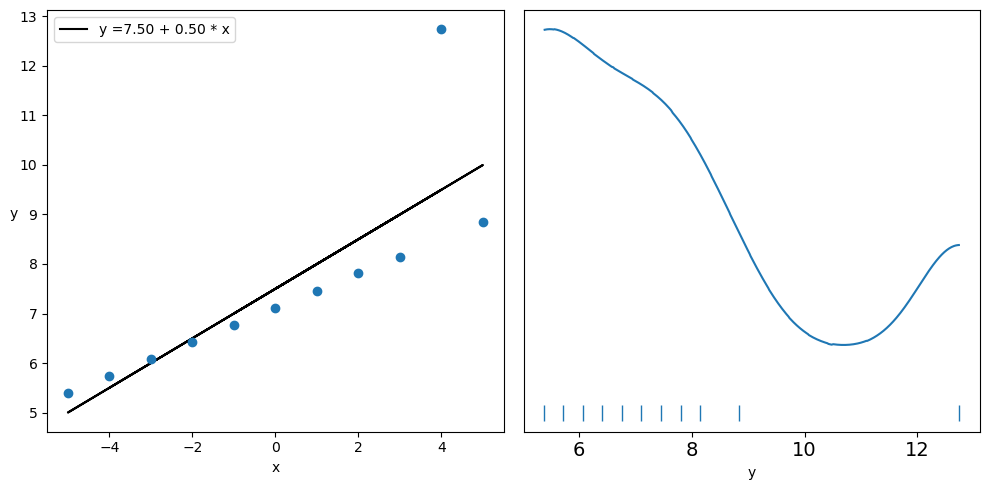

In [12]:

# This is the code for the first plot
# It represents Simple Linear Regression
# We use Gaussian Distribution for the likelihood here

_, ax = plt.subplots(1, 2, figsize=(10, 5))

# calculating the slope and intercept
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2] 

# plotting the regression line
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
 label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')  

# plotting the data points
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()


## For Robust Linear Regression


### Using Student T distribution for the likelihood of the Model

In [14]:
# Using Student T Distribution for the likelihood
# We use the same code as above, but we change the likelihood distribution
trace_t = None
with pm.Model() as model_t:
 α = pm.Normal('α', mu=y_3.mean(), sd=1)
 β = pm.Normal('β', mu=0, sd=1)
 ϵ = pm.HalfNormal('ϵ', 5)
 ν_ = pm.Exponential('ν_', 1/29)
 ν = pm.Deterministic('ν', ν_ + 1)
 y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
 sd=ϵ, nu=ν, observed=y_3)
 trace_t = pm.sample(2000)


e:\Anaconda\envs\pm3bap\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The acceptance probability does not match the target. It is 0.7201282736130606, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


### Calulating the slope and intercept

In [15]:
# Plotting the Robust regression line and Comparing to our previous plot of Simple Linear Regression

beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]       # calculating the slope and intercept of robust linear regression
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()

### Plotting the Regression Lines (robust and simple linear)

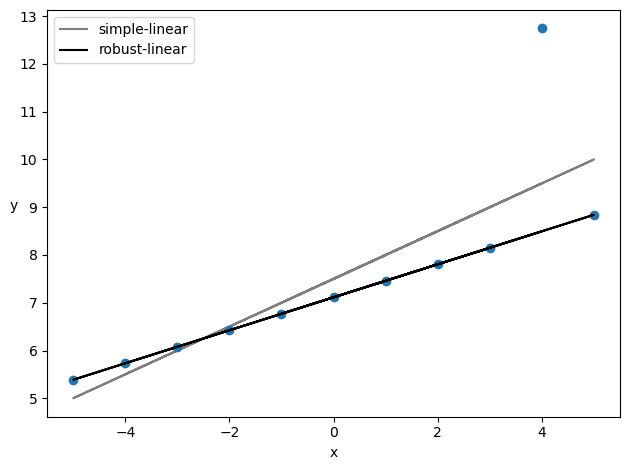

In [16]:
plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='simple-linear', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust-linear')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

### Alpha, Beta and Sigma values for the best-fit line (robust regression line)

In [19]:
az.summary(trace_t)

e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.111,7.117,0.000,0.000,3683.0,3540.0,1.00
β,0.345,0.000,0.345,0.346,0.000,0.000,3135.0,3261.0,1.00
ϵ,0.003,0.002,0.001,0.006,0.000,0.000,348.0,95.0,1.01
ν_,0.206,0.207,0.000,0.593,0.003,0.002,893.0,160.0,1.00
ν,1.206,0.207,1.000,1.593,0.003,0.002,893.0,160.0,1.00


C:\Users\ahmad\AppData\Local\Temp\ipykernel_15792\4069898788.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_t, var_names=['α', 'β', 'ϵ'])
e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


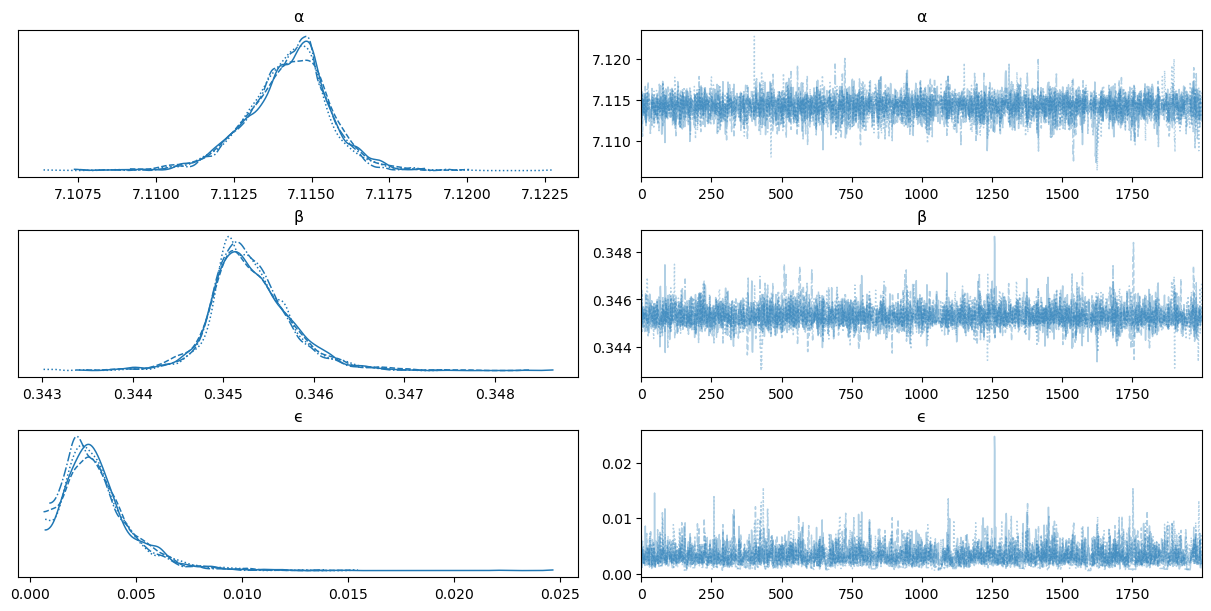

e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


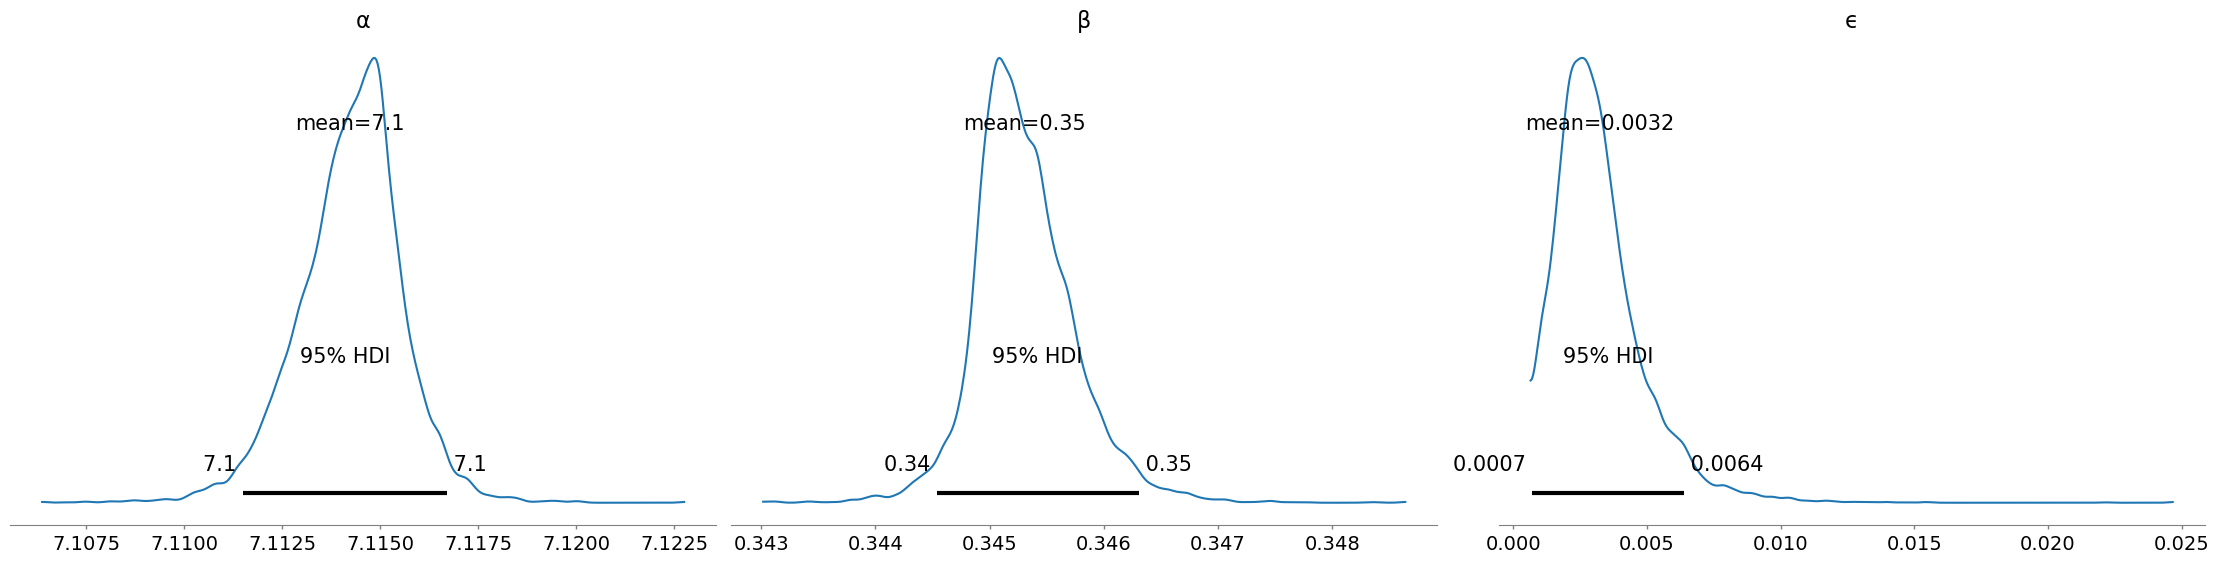

In [ ]:
pm.traceplot(trace_t, var_names=['α', 'β', 'ϵ'])
plt.show()
pm.plot_posterior(trace_t, var_names=['α', 'β', 'ϵ'], hdi_prob=0.95)
plt.show()

**Figure shows α, β, ϵ values for the best fit line**

The trace plot and posterior plot show the posterior distributions for the parameters 'α', 'β', and 'ϵ' for the best-fit line obtained from the Bayesian model. These distributions provide insights into the uncertainty and variability in the parameter values.

### Using Posterior Predictive Check to see How Well our Model Captures the Data

e:\Anaconda\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(0.0, 12.0)

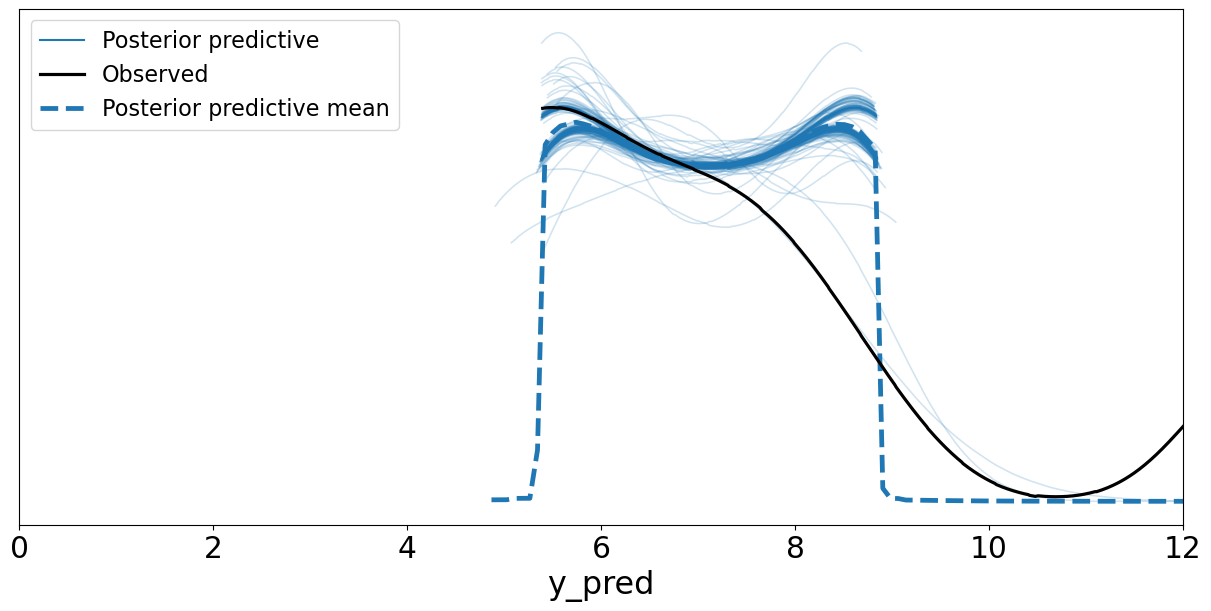

In [20]:
ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t,
random_seed=2)
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
plt.xlim(0, 12)